# Прогноз количества банкротств компаний
### Автор: Гутарева Елена
### Дата: 14.12.2025
### Источник исторических данных: Федресурс (fedresurs.ru)

## 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

## 2. Создание DataFrame из данных

In [2]:
data = {
    'year': [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    'value': [6670, 10072, 10805, 12961, 13027, 12539, 13528, 13102, 12392, 9919, 10298, 9046, 7395, 8562, 6325]
}

df = pd.DataFrame(data)
df.set_index('year', inplace=True)
values = df['value'].values
df

,value
year,
2011,6670
2012,10072
2013,10805
2014,12961
2015,13027
2016,12539
2017,13528
2018,13102
2019,12392


## 3. Разделение данных на train и test

In [3]:
train_size = len(df) - 3
train = df.iloc[:train_size]  # 2011-2022
test = df.iloc[train_size:]   # 2023-2025

## 4. Тестирование моделей Exponential Smoothing

1. Simple (Простая): Нет тренда, нет сезонности. Формула: ŷ_{t+1} = α*y_t + (1-α)*ŷ_t

2. Holt Linear (Хольта линейный): Учитывает тренд.
Формулы: Уровень: l_t = α*y_t + (1-α)*(l_{t-1} + b_{t-1})
Тренд: b_t = β*(l_t - l_{t-1}) + (1-β)*b_{t-1}
Прогноз: ŷ_{t+h} = l_t + h*b_t

3. Holt Damped (Хольта с затуханием): Тренд с затуханием. Формула: ŷ_{t+h} = l_t + (φ + φ² + ... + φ^h)*b_t,
φ (phi) < 1 → тренд постепенно сглаживается

MAE = Mean Absolute Error, Средняя Абсолютная Ошибка
MAE = (1/n) * Σ|y_i - ŷ_i|

In [4]:
models_results = {}

In [5]:
# МОДЕЛЬ 1: Exponential Smoothing с автоматической оптимизацией
print("\n1. Exponential Smoothing (автоматическая оптимизация)")

# Пробуем разные варианты Exponential Smoothing
model_configs = [
    ('Simple', {'trend': None, 'seasonal': None, 'damped_trend': False}),
    ('Holt Linear', {'trend': 'add', 'seasonal': None, 'damped_trend': False}),
    ('Holt Damped', {'trend': 'add', 'seasonal': None, 'damped_trend': True}),
]

best_es_model = None
best_es_mae = float('inf')

try:
    for name, config in model_configs:
        try:
            model = ExponentialSmoothing(
                train['value'],
                trend=config['trend'],
                seasonal=config['seasonal'],
                damped_trend=config['damped_trend'],
                initialization_method='estimated'
            )
            
            model_fit = model.fit(optimized=True)
            forecast = model_fit.forecast(len(test))
            
            # Вычисляем ошибку
            mae = np.mean(np.abs(forecast.values - test['value'].values))
            
            if mae < best_es_mae:
                best_es_mae = mae
                best_es_model = (name, model_fit, forecast)
            
            print(f"  {name}: MAE = {mae:.0f}")
            
        except Exception as e:
            print(f"  Ошибка в модели {name}: {e}")
            continue
    
    if best_es_model:
        models_results['Exponential_Smoothing'] = {
            'name': best_es_model[0],
            'model': best_es_model[1],
            'forecast': best_es_model[2],
            'mae': best_es_mae
        }
        print(f"✓ Лучшая Exponential Smoothing модель: {best_es_model[0]} (MAE: {best_es_mae:.0f})")
    else:
        print("✗ Не удалось обучить ни одну модель Exponential Smoothing")
        
except Exception as e:
    print(f"  Общая ошибка в Exponential Smoothing: {e}")


1. Exponential Smoothing (автоматическая оптимизация)
  Simple: MAE = 1619
  Holt Linear: MAE = 1607
  Holt Damped: MAE = 1739
✓ Лучшая Exponential Smoothing модель: Holt Linear (MAE: 1607)


## 6. Тестирование моделей ARIMA

Различия ARIMA моделей (p,d,q)
1. ARIMA(1, 1, 1) - "Базовый ARIMA"
p=1: AR(1) - зависит от 1 предыдущего значения
d=1: 1 дифференцирование - убирает тренд
q=1: MA(1) - учитывает 1 предыдущую ошибку
Баланс: И авторегрессия, и скользящее среднее

2. ARIMA(2, 1, 2) - "Более сложный"
p=2: AR(2) - зависит от 2 предыдущих значений
d=1: 1 дифференцирование - убирает тренд
q=2: MA(2) - учитывает 2 предыдущие ошибки

3. ARIMA(0, 1, 1) - "Простой MA"
p=0: НЕТ авторегрессии
d=1: 1 дифференцирование - убирает тренд
q=1: MA(1) - учитывает 1 предыдущую ошибку
Для: Ряды без автокорреляции, только шум

4. ARIMA(1, 0, 0) - "Простой AR"
p=1: AR(1) - зависит от 1 предыдущего значения
d=0: НЕТ дифференцирования - ряд уже стационарен
q=0: НЕТ скользящего среднего
Для: Стационарные ряды без тренда

In [6]:
# МОДЕЛЬ 2: ARIMA с автоматическим подбором параметров
print("\n2. ARIMA модели")
try:
    # Пробуем разные порядки ARIMA
    arima_orders = [
        (1, 1, 1),  # Базовый ARIMA
        (2, 1, 2),  # Более сложный
        (0, 1, 1),  # Простой MA
        (1, 0, 0),  # Простой AR
    ]
    
    best_arima_model = None
    best_arima_mae = float('inf')
    
    for order in arima_orders:
        try:
            model = ARIMA(train['value'], order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(len(test))
            
            mae = np.mean(np.abs(forecast.values - test['value'].values))
            
            if mae < best_arima_mae:
                best_arima_mae = mae
                best_arima_model = (order, model_fit, forecast)
            
            print(f"  ARIMA{order}: MAE = {mae:.0f}, AIC = {model_fit.aic:.1f}")
            
        except Exception as e:
            continue
    
    if best_arima_model:
        models_results['ARIMA'] = {
            'order': best_arima_model[0],
            'model': best_arima_model[1],
            'forecast': best_arima_model[2],
            'mae': best_arima_mae
        }
        print(f"✓ Лучшая ARIMA модель: ARIMA{best_arima_model[0]} (MAE: {best_arima_mae:.0f})")
        
except Exception as e:
    print(f"  Ошибка в ARIMA: {e}")


2. ARIMA модели
  ARIMA(1, 1, 1): MAE = 1033, AIC = 193.9
  ARIMA(2, 1, 2): MAE = 1245, AIC = 196.2
  ARIMA(0, 1, 1): MAE = 1111, AIC = 194.0
  ARIMA(1, 0, 0): MAE = 1949, AIC = 216.0
✓ Лучшая ARIMA модель: ARIMA(1, 1, 1) (MAE: 1033)


## 7. Тестирование простых моделей

Простые модели:
- Простое среднее последних трех лет
- Скользящее среднее последних 5 лет
- Линейная экстраполяция последних трех лет

In [7]:
# МОДЕЛЬ 3: Простое среднее последних N лет
print("\n3. Простые модели...")
simple_models = {}

# Среднее последних 3 лет
last_3_mean = train['value'].iloc[-3:].mean()
forecast_3mean = pd.Series([last_3_mean] * len(test), index=test.index)
mae_3mean = np.mean(np.abs(forecast_3mean.values - test['value'].values))
simple_models['Last3_Mean'] = {'forecast': forecast_3mean, 'mae': mae_3mean}
print(f"  Среднее последних 3 лет: MAE = {mae_3mean:.0f}")

# Скользящее среднее последних 5 лет
last_5_mean = train['value'].iloc[-5:].mean()
forecast_5mean = pd.Series([last_5_mean] * len(test), index=test.index)
mae_5mean = np.mean(np.abs(forecast_5mean.values - test['value'].values))
simple_models['Last5_Mean'] = {'forecast': forecast_5mean, 'mae': mae_5mean}
print(f"  Среднее последних 5 лет: MAE = {mae_5mean:.0f}")

# Линейная экстраполяция последних 3 точек
if len(train) >= 3:
    x = np.arange(3)
    y = train['value'].iloc[-3:].values
    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)
    forecast_linear = poly(np.arange(3, 3 + len(test)))
    forecast_linear_series = pd.Series(forecast_linear, index=test.index)
    mae_linear = np.mean(np.abs(forecast_linear_series.values - test['value'].values))
    simple_models['Linear_Extrapolation'] = {'forecast': forecast_linear_series, 'mae': mae_linear}
    print(f"  Линейная экстраполяция: MAE = {mae_linear:.0f}")

# Выбираем лучшую простую модель
best_simple_name = min(simple_models, key=lambda x: simple_models[x]['mae'])
best_simple = simple_models[best_simple_name]
models_results['Simple'] = {
    'name': best_simple_name,
    'forecast': best_simple['forecast'],
    'mae': best_simple['mae']
}
print(f"✓ Лучшая простая модель: {best_simple_name} (MAE: {best_simple['mae']:.0f})")


3. Простые модели...
  Среднее последних 3 лет: MAE = 2327
  Среднее последних 5 лет: MAE = 3524
  Линейная экстраполяция: MAE = 1096
✓ Лучшая простая модель: Linear_Extrapolation (MAE: 1096)


In [8]:
# 3. ВЫБОР ЛУЧШЕЙ МОДЕЛИ
print("\n" + "="*50)
print("ВЫБОР ЛУЧШЕЙ МОДЕЛИ")
print("="*50)

best_overall_model = None
best_overall_mae = float('inf')

for model_type, results in models_results.items():
    print(f"{model_type}: MAE = {results['mae']:.0f}")
    if results['mae'] < best_overall_mae:
        best_overall_mae = results['mae']
        best_overall_model = (model_type, results)

print(f"\n✓ ЛУЧШАЯ МОДЕЛЬ: {best_overall_model[0]} (MAE: {best_overall_mae:.0f})")


ВЫБОР ЛУЧШЕЙ МОДЕЛИ
Exponential_Smoothing: MAE = 1607
ARIMA: MAE = 1033
Simple: MAE = 1096

✓ ЛУЧШАЯ МОДЕЛЬ: ARIMA (MAE: 1033)


## 8. Прогноз лучшей модели - Базовый ARIMA

In [9]:
# ОЦЕНКА КАЧЕСТВА МОДЕЛИ
print("\n" + "-"*60)
print("ОЦЕНКА КАЧЕСТВА ARIMA(1,1,1)")
print("-"*60)
        
# Обучаем на тренировочных данных
train_model = ARIMA(train, order=(1, 1, 1))
train_model_fit = train_model.fit()
            
# Прогноз на тестовую выборку
test_forecast = train_model_fit.forecast(steps=len(test))
            
# Расчет MAE на тесте
best_mae = mean_absolute_error(test['value'], test_forecast)
            
print(f"MAE на тестовой выборке: {best_mae:.0f}")
print(f"Относительная ошибка: {(best_mae / test['value'].mean() * 100):.1f}%")


------------------------------------------------------------
ОЦЕНКА КАЧЕСТВА ARIMA(1,1,1)
------------------------------------------------------------
MAE на тестовой выборке: 1033
Относительная ошибка: 13.9%


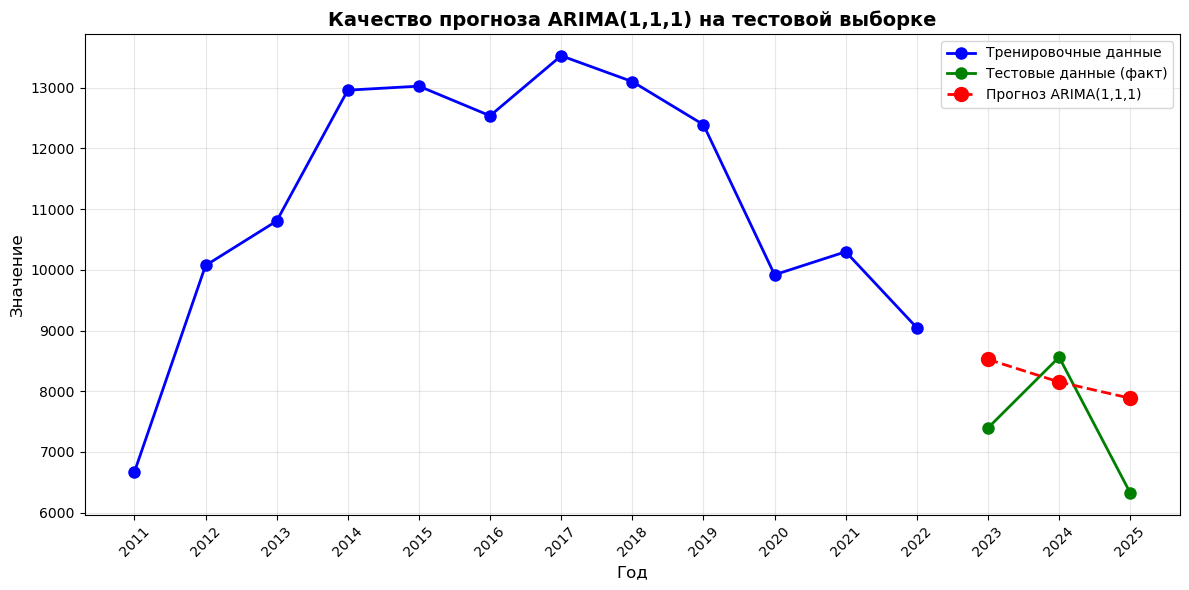

In [10]:
# Визуализация
plt.figure(figsize=(12, 6))
            
# Все годы как целые числа
train_years = list(df.index[:-len(test)])
test_years = list(test.index)

plt.plot(train_years, df['value'].iloc[:-len(test)], 'bo-', 
                    linewidth=2, markersize=8, label='Тренировочные данные')
plt.plot(test_years, test['value'], 'go-', 
                    linewidth=2, markersize=8, label='Тестовые данные (факт)')
plt.plot(test_years, test_forecast, 'ro--', 
                    linewidth=2, markersize=10, label='Прогноз ARIMA(1,1,1)')
            
# Настройка оси X - только целые годы
all_years = train_years + test_years
plt.xticks(all_years, rotation=45)
plt.title('Качество прогноза ARIMA(1,1,1) на тестовой выборке', 
                     fontsize=14, fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# ПРОГНОЗ ПО ARIMA(1,1,1) И ЕГО ВИЗУАЛИЗАЦИЯ
print("\n" + "="*60)
print("ПРОГНОЗ ПО ARIMA(1,1,1)")
print("="*60)

# Параметры прогноза
forecast_years = 3
future_years = list(range(df.index[-1] + 1, df.index[-1] + 1 + forecast_years))

print(f"Строим прогноз на {forecast_years} года вперед: {future_years[0]}-{future_years[-1]}")

# Обучение ARIMA(1,1,1) на всех данных
from statsmodels.tsa.arima.model import ARIMA

print(f"Обучение ARIMA(1,1,1) на данных ({df.index[0]}-{df.index[-1]})...")
arima_model = ARIMA(df['value'], order=(1, 1, 1))
arima_fit = arima_model.fit()

# Прогноз на будущие годы
arima_forecasts = arima_fit.forecast(steps=forecast_years).tolist()

# Получаем доверительные интервалы
forecast_result = arima_fit.get_forecast(steps=forecast_years)
conf_int = forecast_result.conf_int()

# Подготавливаем данные для 80% доверительных интервалов
lower_80_vals = []
upper_80_vals = []
upper_95_vals = conf_int.iloc[:, 1].values

# Расчет 80% доверительных интервалов
for i in range(len(arima_forecasts)):
    lower_80 = arima_forecasts[i] - 1.28 * (upper_95_vals[i] - arima_forecasts[i]) / 1.96
    upper_80 = arima_forecasts[i] + 1.28 * (upper_95_vals[i] - arima_forecasts[i]) / 1.96
    lower_80_vals.append(lower_80)
    upper_80_vals.append(upper_80)

# Вывод прогноза
print(f"\nПрогноз ARIMA(1,1,1) на {future_years[0]}-{future_years[-1]}:")
for i, year in enumerate(future_years):
    print(f"  {year}: {arima_forecasts[i]:.0f} (80% ДИ: {lower_80_vals[i]:.0f}-{upper_80_vals[i]:.0f})")

# Параметры модели
print(f"\nПараметры ARIMA(1,1,1):")
print(f"• AR(1): {arima_fit.params.get('ar.L1', 'N/A'):.4f}")
print(f"• MA(1): {arima_fit.params.get('ma.L1', 'N/A'):.4f}")
print(f"• AIC: {arima_fit.aic:.1f}")
print(f"• BIC: {arima_fit.bic:.1f}")


ПРОГНОЗ ПО ARIMA(1,1,1)
Строим прогноз на 3 года вперед: 2026-2028
Обучение ARIMA(1,1,1) на данных (2011-2025)...

Прогноз ARIMA(1,1,1) на 2026-2028:
  2026: 5697 (80% ДИ: 3893-7502)
  2027: 5219 (80% ДИ: 2290-8148)
  2028: 4855 (80% ДИ: 878-8832)

Параметры ARIMA(1,1,1):
• AR(1): 0.7617
• MA(1): -0.4830
• AIC: 248.2
• BIC: 250.2


1. AR(1): 0.7617 - Авторегрессионный коэффициент
Что означает: Текущее значение зависит от предыдущего значения на 76.17%

Интерпретация:

Сильная положительная связь с предыдущим периодом

Тренд имеет инерцию - сохраняет направление

Значение близко к 1 (максимум) → высокая устойчивость ряда

2. MA(1): -0.4830 - Коэффициент скользящего среднего
Что означает: Текущая ошибка зависит от предыдущей ошибки

Интерпретация:

Отрицательное значение (-0.48) → компенсирующий эффект

Если в предыдущем периоде была положительная ошибка, модель ее "исправляет"

Стабилизирующий фактор - сглаживает резкие колебания

3. AIC: 248.2 и BIC: 250.2 - Критерии информативности
AIC (Akaike Information Criterion) = 248.2

BIC (Bayesian Information Criterion) = 250.2

Что означают: Меры качества модели с учетом сложности

Правило: Чем меньше - тем лучше

Интерпретация:

Разница всего 2 пункта → модель не переобучена

Значения умеренные для временных рядов


Визуализация прогноза ARIMA(1,1,1)...


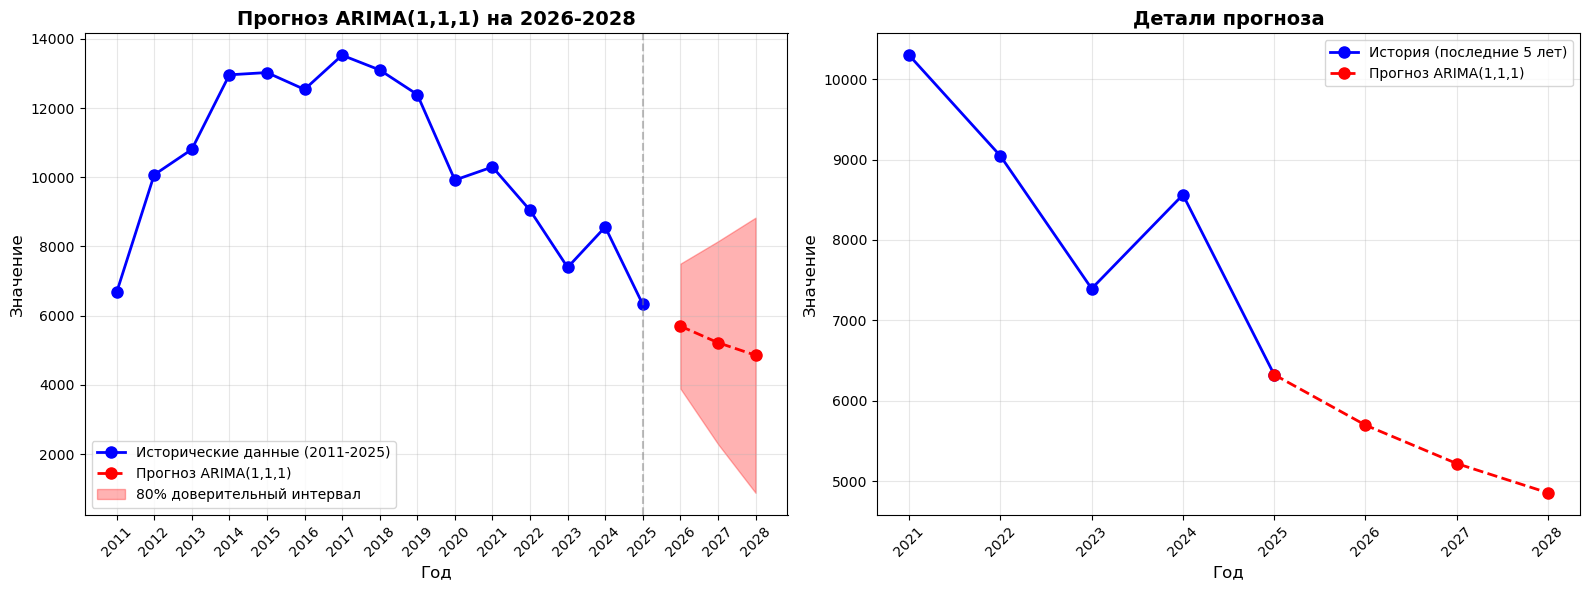

In [18]:
# ВИЗУАЛИЗАЦИЯ ПРОГНОЗА
print(f"\nВизуализация прогноза ARIMA(1,1,1)...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Полный прогноз с историей
axes[0].plot(df.index, df['value'], 'bo-', linewidth=2, markersize=8, 
             label=f'Исторические данные ({df.index[0]}-{df.index[-1]})')
axes[0].plot(future_years, arima_forecasts, 'ro--', 
             linewidth=2, markersize=8, label='Прогноз ARIMA(1,1,1)')

# 80% доверительные интервалы
axes[0].fill_between(future_years, lower_80_vals, upper_80_vals, 
                     alpha=0.3, color='red', label='80% доверительный интервал')

axes[0].axvline(x=df.index[-1], color='gray', linestyle='--', alpha=0.5)

# Настройка оси X
all_years = list(df.index) + future_years
axes[0].set_xticks(all_years)
axes[0].set_xticklabels([int(year) for year in all_years], rotation=45)

axes[0].set_title(f'Прогноз ARIMA(1,1,1) на {future_years[0]}-{future_years[-1]}', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Год', fontsize=12)
axes[0].set_ylabel('Значение', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Детали прогноза
years_display = list(df.index[-5:]) + future_years
values_display = list(df['value'].values[-5:]) + arima_forecasts

axes[1].plot(years_display[:5], values_display[:5], 'bo-', 
             linewidth=2, markersize=8, label='История (последние 5 лет)')
axes[1].plot(years_display[4:], values_display[4:], 'ro--', 
             linewidth=2, markersize=8, label='Прогноз ARIMA(1,1,1)')

# Настройка оси X
axes[1].set_xticks(years_display)
axes[1].set_xticklabels([int(year) for year in years_display], rotation=45)

axes[1].set_title(f'Детали прогноза', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('Год', fontsize=12)
axes[1].set_ylabel('Значение', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()